In [1]:
import numpy as np
import numpy.random as npr
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from scipy import linalg as la

np.set_printoptions(precision = 2, linewidth = np.inf)
%matplotlib inline

BOLD = '\033[1m'
END = '\033[0m'
npr.seed(123)

1\. **PCA on 3D dataset**

* Generate a dataset with 3 features each with N entries (N being ${\cal O}(1000)$). With $N(\mu,\sigma)$ the normali distribution with mean $\mu$ and $\sigma$  standard deviation, generate the 3 variables $x_{1,2,3}$ such that:
    * $x_1$ is distributed as $N(0,1)$
    * $x_2$ is distributed as $x_1+N(0,3)$
    * $x_3$ is given by $2x_1+x_2$
* Find the eigenvectors and eigenvalues of the covariance matrix of the dataset
* Find the eigenvectors and eigenvalues using SVD. Check that the two procedures yield to same result
* What percent of the total dataset's variability is explained by the principal components? Given how the dataset was constructed, do these make sense? Reduce the dimensionality of the system so that at least 99% of the total variability is retained.
* Redefine the data in the basis yielded by the PCA procedure
* Plot the data points in the original and the new coordiantes as a set of scatter plots. Your final figure should have 2 rows of 3 plots each, where the columns show the (0,1), (0,2) and (1,2) proejctions.


In [10]:
N = 1000
x1 = npr.normal(loc = 0, scale = 1, size = N)
x2 = x1 + npr.normal(loc = 0, scale = 3, size = N)
x3 = 2*x1 + x2

df = pd.DataFrame({"x1": x1, "x2": x2, "x3": x3})

In [11]:
# eigenvectors and eigenvalues of the covariance matrix of the dataset

cov = df.cov()
eigenvalues, eigenvectors = la.eig(cov)

print(BOLD + "- Eigendecomposition method" + END)
print("Eigenvalues of the covariance matrix:", np.real_if_close(eigenvalues))
print("\nEigenvectors of the covariance matrix:\n", eigenvectors)

D1 = np.diag(eigenvalues)                   
ein_cov = np.dot(eigenvectors, np.dot(D1, la.inv(eigenvectors)))
print("\nReconstruct covariance:\n", ein_cov)



# eigenvectors and eigenvalues using SVD

U, spectrum, Vt = la.svd(cov)

print(BOLD + "\n\n- SVD method" + END)
print("Eigenvalues of the covariance matrix using SVD:", spectrum)
print("\nEigenvectors of the covariance matrix using SVD:\n", U)

D2 = np.diag(spectrum)                             
SVD_cov = np.dot(U, np.dot(D2, Vt))
print("\nReconstruct covariance:\n", SVD_cov)



# Check that the two procedures yield to same result  

sort1 = np.argsort(eigenvalues)
eigenvalues = eigenvalues[sort1]

'''names = np.array(["x1", "x2", "x3"])
print("\n\n\n", eigenvectors)'''
eigenvectors = eigenvectors[:, sort1]
'''print(sort1)
print(names[1], names[2], names[0])
print(names[sort1])
print(eigenvectors, "\n\n\n")'''

sort2 = np.argsort(spectrum)
spectrum = spectrum[sort2]
U = U[:, sort2]

check_val = np.allclose(eigenvalues, spectrum, rtol = 0, atol = 1e-10)
check_vec =  np.allclose(eigenvectors, U, rtol = 0, atol = 1e-10)
print(BOLD + "\n\n- Comparison" + END)
print("The eigenvalues are the same with tolerance = 1e-10 => ", check_val)
print("The eigenvectors are the same with tolerance = 1e-10 => ", check_vec)

- Eigendecomposition method
Eigenvalues of the covariance matrix: [2.83e+01 1.33e-15 1.97e+00]

Eigenvectors of the covariance matrix:
 [[-0.11 -0.82  0.57]
 [-0.58 -0.41 -0.71]
 [-0.81  0.41  0.43]]

Reconstruct covariance:
 [[ 1.  +0.j  1.09+0.j  3.1 +0.j]
 [ 1.09+0.j 10.43+0.j 12.6 +0.j]
 [ 3.1 +0.j 12.6 +0.j 18.8 +0.j]]


- SVD method
Eigenvalues of the covariance matrix using SVD: [2.83e+01 1.97e+00 1.02e-16]

Eigenvectors of the covariance matrix using SVD:
 [[-0.11  0.57 -0.82]
 [-0.58 -0.71 -0.41]
 [-0.81  0.43  0.41]]

Reconstruct covariance:
 [[ 1.    1.09  3.1 ]
 [ 1.09 10.43 12.6 ]
 [ 3.1  12.6  18.8 ]]


- Comparison
The eigenvalues are the same with tolerance = 1e-10 =>  True
The eigenvectors are the same with tolerance = 1e-10 =>  True


In [12]:
# What percent of the total dataset's variability is explained by the principal components? 

names = np.array(["x1", "x2", "x3"])
names2 = names[sort2]
percent = spectrum/spectrum.sum()
print(BOLD + "- Percentage of the total dataset's variability" + END + "   =>  ", names2, "=", percent*100)

# Reduce the dimensionality of the system so that at least 99% of the total variability is retained
delete = np.argmin(percent)
if np.delete(percent, delete).sum() >= 0.99:
    print(BOLD + "\n- Reducing the dimensionality" + END + "   =>  We can drop the",  names2[delete], "variable")


- Percentage of the total dataset's variability   =>   ['x3' 'x2' 'x1'] = [3.37e-16 6.52e+00 9.35e+01]

- Reducing the dimensionality   =>  We can drop the x3 variable


The eigenvalues in PCA tell us how much variance can be explained by its associated eigenvector. Therefore, the highest eigenvalue indicates the highest variance in the data was observed in the direction of its eigenvector.

$\newline$ Given how the dataset was constructed, do these make sense? It totally make sense knowing the way the three variables has been constructed: 
- $x_1$ has higher the variance: it's completely uncorrelated to the other variables
- $x_2$ has a lower variance respect to $x_1$: it depens on $x_1$ but it has its own variability deriving to a normal distribution
- $x_3$ has the lowest variance: it's a linear combination of $x_1$ and $x_2$

In [13]:
# Redefine the data in the basis yielded by the PCA procedure

df_PCA = pd.DataFrame(np.dot(eigenvectors.T, df.T).T, columns = names[sort1])
df_PCA

,x2,x3,x1
0,-9.813572e-17,0.058769,-0.760179
1,1.768094e-15,-0.943827,8.239752
2,-6.755484e-16,0.586631,-2.138381
3,-6.955773e-16,0.524566,-4.558792
4,1.020621e-15,-1.353385,0.642676
...,...,...,...
995,-1.227777e-15,1.726875,-0.923757
996,-4.514622e-17,-0.110346,-1.492493
997,-1.495597e-15,1.280124,-5.498068
998,-2.313717e-16,0.158453,-2.166624


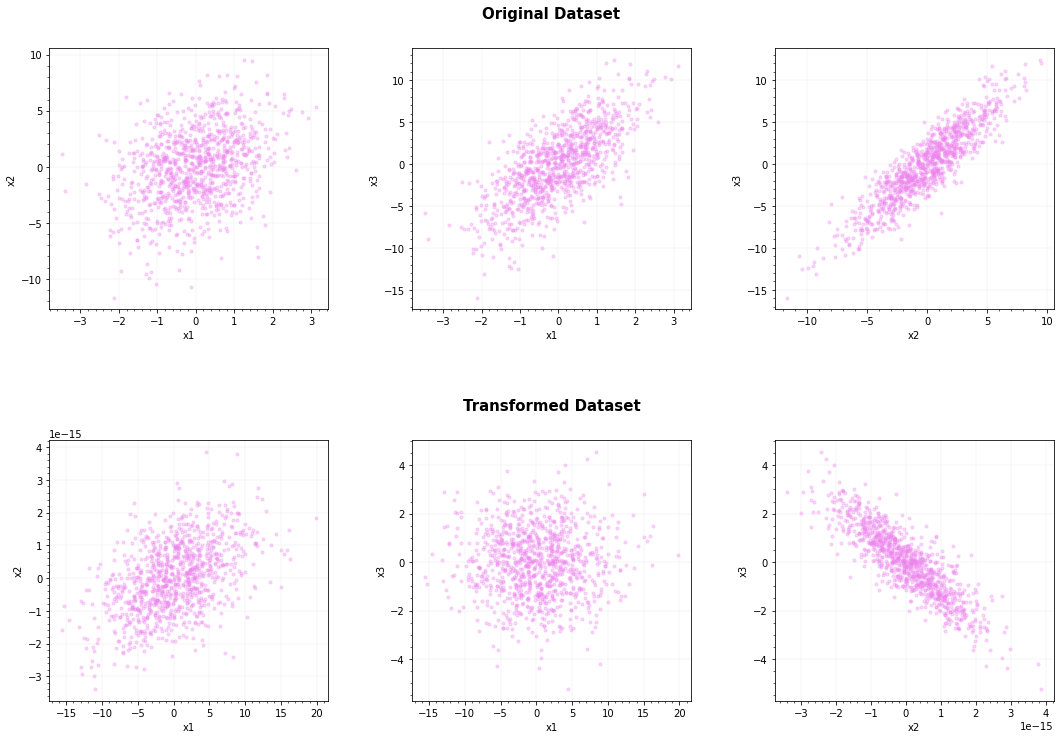

In [14]:
# Plot the data points in the original and the new coordiantes as a set of scatter plots


fig, ax = plt.subplots(2, 3, figsize = (18, 12))
fig.subplots_adjust(hspace = 0.5, wspace = 0.3)

ax[0,0].scatter(df.x1, df.x2, color = "violet", alpha = 0.3, s = 10)
ax[0,0].set(xlabel = "x1", ylabel = "x2")
ax[0,0].grid(lw = 0.1)
ax[0,0].minorticks_on()

ax[0,1].set_title("Original Dataset", y = 1, pad = 30, fontsize = 15, weight = "bold")
ax[0,1].scatter(df.x1, df.x3, color = "violet", alpha = 0.3, s = 10)
ax[0,1].set(xlabel = "x1", ylabel = "x3")
ax[0,1].grid(lw = 0.1)
ax[0,1].minorticks_on()

ax[0,2].scatter(df.x2, df.x3, color = "violet", alpha = 0.3, s = 10)
ax[0,2].set(xlabel = "x2", ylabel = "x3")
ax[0,2].grid(lw = 0.1)
ax[0,2].minorticks_on()

ax[1,0].scatter(df_PCA.x1, df_PCA.x2, color = "violet", alpha = 0.3, s = 10)
ax[1,0].set(xlabel = "x1", ylabel = "x2")
ax[1,0].grid(lw = 0.1)
ax[1,0].minorticks_on()

ax[1,1].set_title("Transformed Dataset", y = 1, pad = 30, fontsize = 15, weight = "bold")
ax[1,1].scatter(df_PCA.x1, df_PCA.x3, color = "violet", alpha = 0.3, s = 10)
ax[1,1].set(xlabel = "x1", ylabel = "x3")
ax[1,1].grid(lw = 0.1)
ax[1,1].minorticks_on()

ax[1,2].scatter(df_PCA.x2, df_PCA.x3, color = "violet", alpha = 0.3, s = 10)
ax[1,2].set(xlabel = "x2", ylabel = "x3")
ax[1,2].grid(lw = 0.1)
ax[1,2].minorticks_on()

plt.show()

2\. **PCA on a nD dataset**

Start from the dataset you have genereted in the previous exercise and add uncorrelated random noise. Such noise should be represented by other 10 uncorrelated variables normal distributed, with standar deviation much smaller (say, a factor 50) than those used to generate the $x_1$ and $x_2$.

Repeat the PCA procedure and compare the results with what you obtained before

In [16]:
# Start from the dataset you have genereted in the previous exercise and add uncorrelated random noise


df_new = df.copy(deep = True)
for i in range(4, 14):
    df_new["x"+str(i)] = npr.normal(loc = 0, scale = 1/npr.randint(50, 80), size = N)

df_new

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13
0,0.120581,0.397930,0.639091,-0.032792,0.015337,0.014676,-0.014446,-0.003271,0.002128,0.027056,0.005474,0.009405,-0.013446
1,-1.480601,-4.096485,-7.057687,-0.003700,0.006311,-0.003987,-0.004223,-0.020543,0.000227,0.021365,-0.000155,-0.047064,-0.011362
2,0.577575,0.821716,1.976866,-0.007840,-0.009885,-0.013485,0.001014,-0.012621,-0.014184,-0.013041,-0.008016,0.003620,0.006940
3,0.820514,2.264775,3.905804,-0.008424,0.007911,-0.010240,0.008237,0.029650,-0.018460,0.006534,0.004940,0.012877,-0.034955
4,-0.839583,0.584648,-1.094519,0.006767,-0.001889,-0.007176,0.006952,0.006628,-0.013244,0.017446,-0.003477,0.001783,0.003466
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.083196,-0.686031,1.480362,0.001710,0.012400,0.020038,0.010560,-0.010229,-0.024609,0.018044,0.019151,-0.001159,-0.004729
996,0.109022,0.940752,1.158797,-0.003422,-0.006123,0.003868,0.005202,0.005770,0.008885,0.019558,0.002938,-0.008313,-0.027118
997,1.355917,2.273955,4.985788,-0.000494,0.006835,-0.006791,-0.011427,0.008008,0.011860,0.014808,0.016782,0.031783,-0.005745
998,0.338554,1.140552,1.817660,0.017149,-0.003418,0.014903,-0.000720,-0.008957,0.008909,0.003154,-0.005299,0.012510,-0.024756


In [17]:
# Repeat the PCA procedure and compare the results with what you obtained before

cov_new = df_new.cov()
eigenval, eigenvect = la.eig(cov_new)

name = np.array(["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "x9", "x10", "x11", "x12", "x13"])
sorta = np.flip(np.argsort(eigenval))
eigenval = eigenval[sorta]
name = name[sorta]

percentage = np.real_if_close(eigenval/eigenval.sum())

print(BOLD + "- Percentage of the total dataset's variability" + END + "\n   => ",
      name, "\n   => ", percentage*100)

print("\n   => The sum of the percentages of x1 and x2 is %.3f, which encapsulates the larger part of the\
 dataset variability" %((percentage[0]+percentage[1])*100))
print("   => Similar situation of the previous case! " )

- Percentage of the total dataset's variability
   =>  ['x1' 'x2' 'x4' 'x5' 'x6' 'x7' 'x8' 'x9' 'x10' 'x12' 'x13' 'x11' 'x3'] 
   =>  [9.35e+01 6.52e+00 1.36e-03 1.27e-03 1.04e-03 9.63e-04 8.51e-04 7.59e-04 6.44e-04 5.73e-04 5.67e-04 5.24e-04 8.82e-15]

   => The sum of the percentages of x1 and x2 is 99.991, which encapsulates the larger part of the dataset variability
   => Similar situation of the previous case! 


In [18]:
df_new_PCA = pd.DataFrame(np.dot(eigenvect.T, df_new.T).T)
df_new_PCA

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.760185,0.058754,2.431832e-17,0.019817,0.013481,0.015597,-0.003371,-0.019471,0.030713,0.006601,-0.003048,-0.015754,-0.017911
1,-8.239759,-0.943811,-2.372116e-16,0.030310,0.006490,-0.039989,0.004173,-0.023451,-0.000738,0.000165,0.005476,-0.000669,-0.007731
2,2.138383,0.586638,-4.811757e-16,-0.005208,-0.017110,-0.001241,-0.015322,-0.003822,0.003706,-0.005614,0.006636,0.016464,0.007165
3,4.558794,0.524540,-8.869242e-17,0.009916,-0.009647,0.031938,0.035387,-0.013813,0.005250,0.014399,0.006076,0.006204,0.004918
4,-0.642677,-1.353388,2.024521e-15,0.020152,-0.002066,0.006849,0.002509,0.009861,-0.005109,0.000787,0.002583,0.009024,0.004168
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.923756,1.726893,-2.550910e-15,0.029073,-0.011337,0.004297,-0.005818,-0.002872,-0.002722,0.022273,-0.007327,-0.020832,0.003253
996,1.492490,-0.110355,3.410622e-16,0.014829,0.017581,0.001324,0.019777,-0.018335,0.002017,0.001776,-0.008124,-0.002184,0.008427
997,5.498073,1.280098,-1.040264e-15,-0.001536,0.021553,0.032571,-0.000428,0.000718,0.002838,0.002575,0.016346,-0.013283,-0.000975
998,2.166621,0.158460,3.611063e-16,-0.002315,0.012623,0.013475,0.000248,-0.017919,-0.021046,-0.001047,-0.018915,-0.005953,0.001147
